In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
from torchtext.vocab import build_vocab_from_iterator
import pickle
from pmf import PMF
from lr import LogReg
import numpy as np
from functools import reduce

from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import numpy as np
import torch
import matplotlib.pylab as plt
import seaborn as sns

import pandas as pd

/Users/zekeweng/.pyenv/versions/3.9.10/lib/python3.9/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/Users/zekeweng/.pyenv/versions/3.9.10/lib/python3.9/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [2]:
SEED = 42
REPLACEMENT_LEVELS = [25, 50, 100, 250, 500, 1000]
LATENT_FACTORS = [1, 2, 3, 4, 5, 6]

df = pd.read_csv('data/men_data.csv')

In [5]:
def get_athlete_accuracy(df, model, names):
    accuracies = []
    for name in reversed(names):
        if name != 'other':
            df_climber = df.loc[df.Name == name]
        else:
            mask = df.Name.isin([climber for climber in model.climber_vocab.get_itos() if climber != 'other'])
            df_climber= df.loc[~mask]

        y_true = df_climber['Status'].values
        y_pred = model.predict(df_climber)
        y_pred_binary = np.round(y_pred)
        accuracies.append(accuracy_score(y_true, y_pred_binary))
    return accuracies

def get_athlete_counts(df, model, names):
    accuracies = []
    for name in names:
        if name != 'other':
            df_climber = df.loc[df.Name == name]
        else:
            mask = df.Name.isin([climber for climber in model.climber_vocab.get_itos() if climber != 'other'])
            df_climber= df.loc[~mask]
        accuracies.append(df_climber.shape[0])
    return accuracies

In [15]:


def create_correlation_matrices():
    athletes = {}

    for replacement_level in REPLACEMENT_LEVELS:
        with open(f"models/lr/model_rl_{replacement_level}_fold_0.pkl", 'rb') as f:            ########## CHANGE PATH FOR COMPLETE MODEL
            lr_model = pickle.load(f)

        fig, axs = plt.subplots(nrows=1, ncols=len(LATENT_FACTORS), figsize=(28, 8))

        for num_factors in LATENT_FACTORS:
            # lr_weights = dict(zip(lr_model.climber_vocab.get_itos(), [lr_model.lr.intercept_[0]] + lr_model.lr.coef_.flatten().tolist())) ### WITH OTHER
            lr_climbers = lr_model.climber_vocab.get_itos()[1:]
            lr_athletes = pd.DataFrame({
                "coefs": lr_model.lr.coef_.flatten().tolist(),
            }, index=lr_climbers)

            pmf_model = torch.load(f"models/pmf/model_rl_{replacement_level}_d_{num_factors}_fold_1.pth")  ########## CHANGE PATH FOR COMPLETE MODEL
            pmf_model.eval()


            pmf_climbers = pmf_model.climber_vocab.get_itos()[1:]
            pmf_athletes = pd.DataFrame({
                "weights": pmf_model.climber_embedding.weight.data.numpy().tolist()[1:],
                "pmf_accuracy": get_athlete_accuracy(df, pmf_model, pmf_climbers),
                "size": get_athlete_counts(df, pmf_model, pmf_climbers),
            }, index=pmf_climbers)

            weights = pmf_athletes['weights'].apply(pd.Series)
            pmf_athletes = pd.concat([pmf_athletes[['pmf_accuracy','size']], weights], axis=1)
            pmf_athletes.columns = ['pmf_accuracy', 'size'] + [f'weight_{i+1}' for i in range(weights.shape[1])]

            ### Correlations
            lr_pmf_athletes = pd.merge(lr_athletes, pmf_athletes, left_index=True, right_index=True, how='outer')
            rows = [row for row in lr_pmf_athletes.columns if row.startswith('w')]
            cols = ['coefs','pmf_accuracy','size']
            df_corr = lr_pmf_athletes.corr().loc[rows, cols]
            sns.heatmap(df_corr, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, ax=axs[num_factors-1])


            athletes[f'{replacement_level}_{num_factors}'] = lr_pmf_athletes

        plt.suptitle(f'Correlation Matrices at RL: {replacement_level}', fontsize=16)

        plt.tight_layout()
        plt.savefig(f'figs/correlations_{replacement_level}')

    return athletes

/Users/zekeweng/.pyenv/versions/3.9.10/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.5.1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/zekeweng/.pyenv/versions/3.9.10/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.5.1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/zekeweng/.pyenv/versions/3.9.10/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Logisti

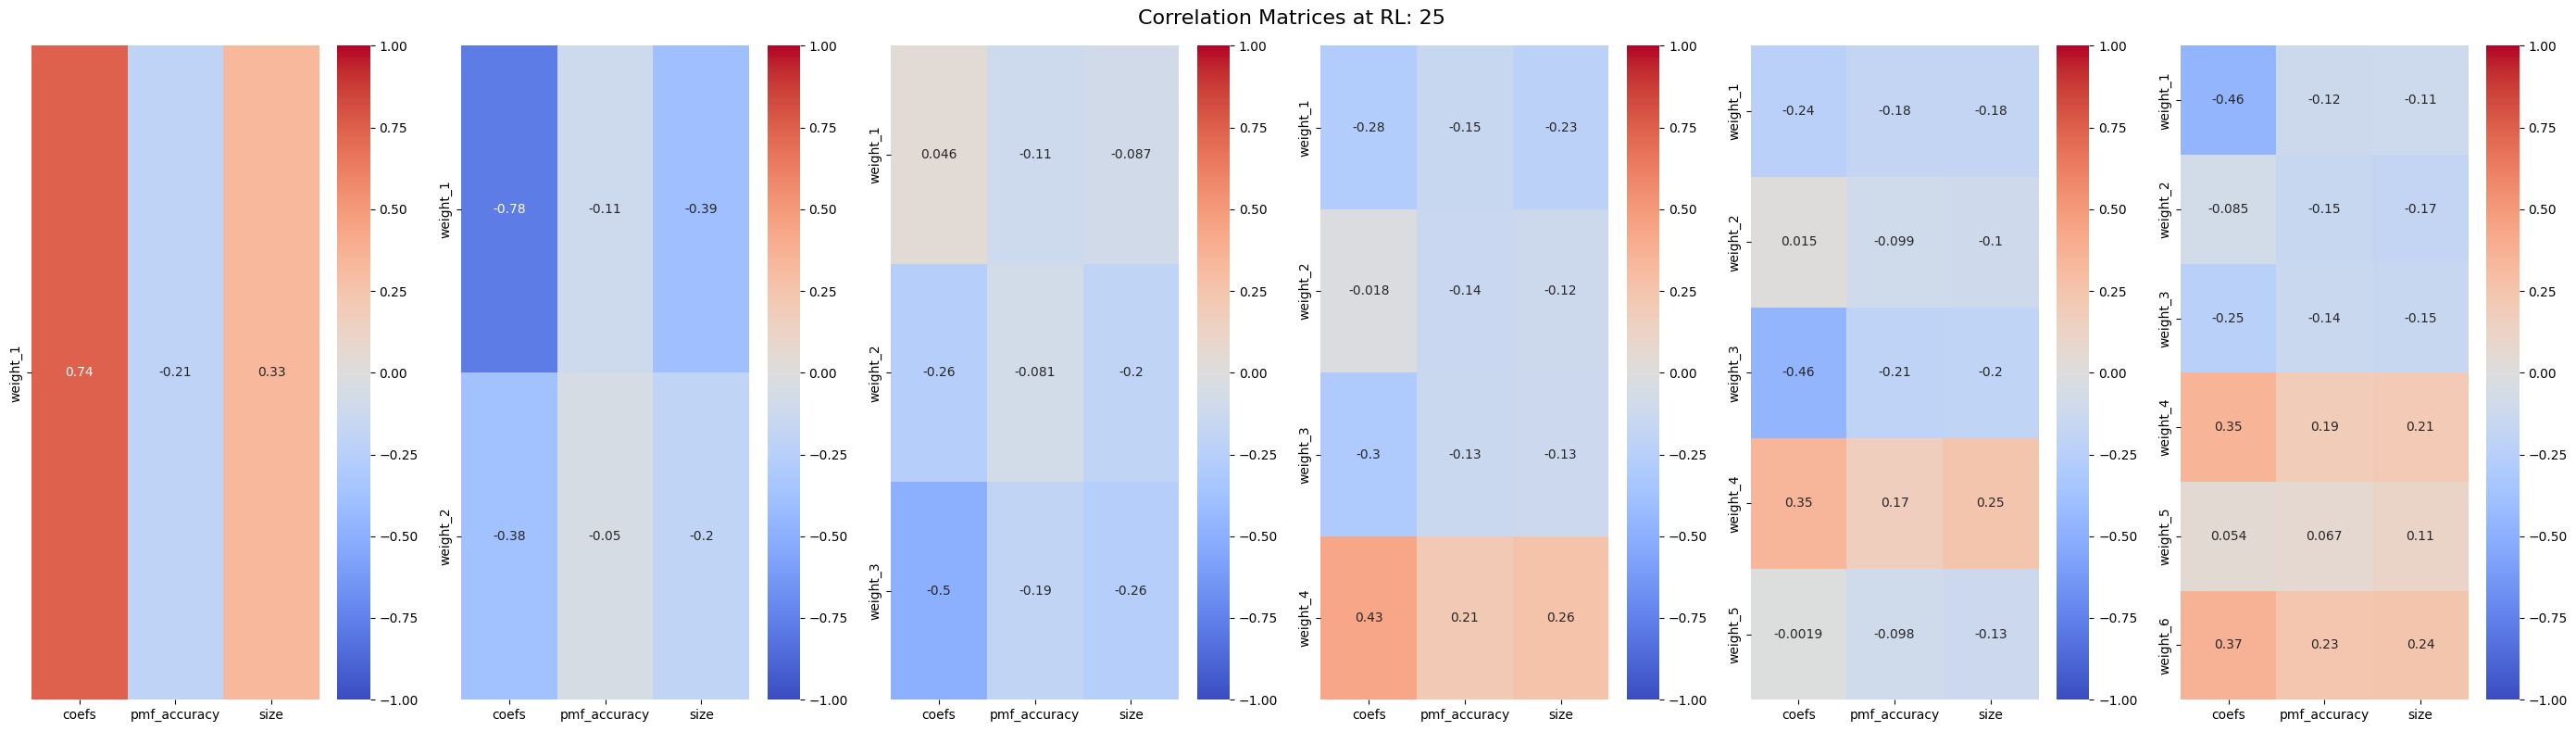

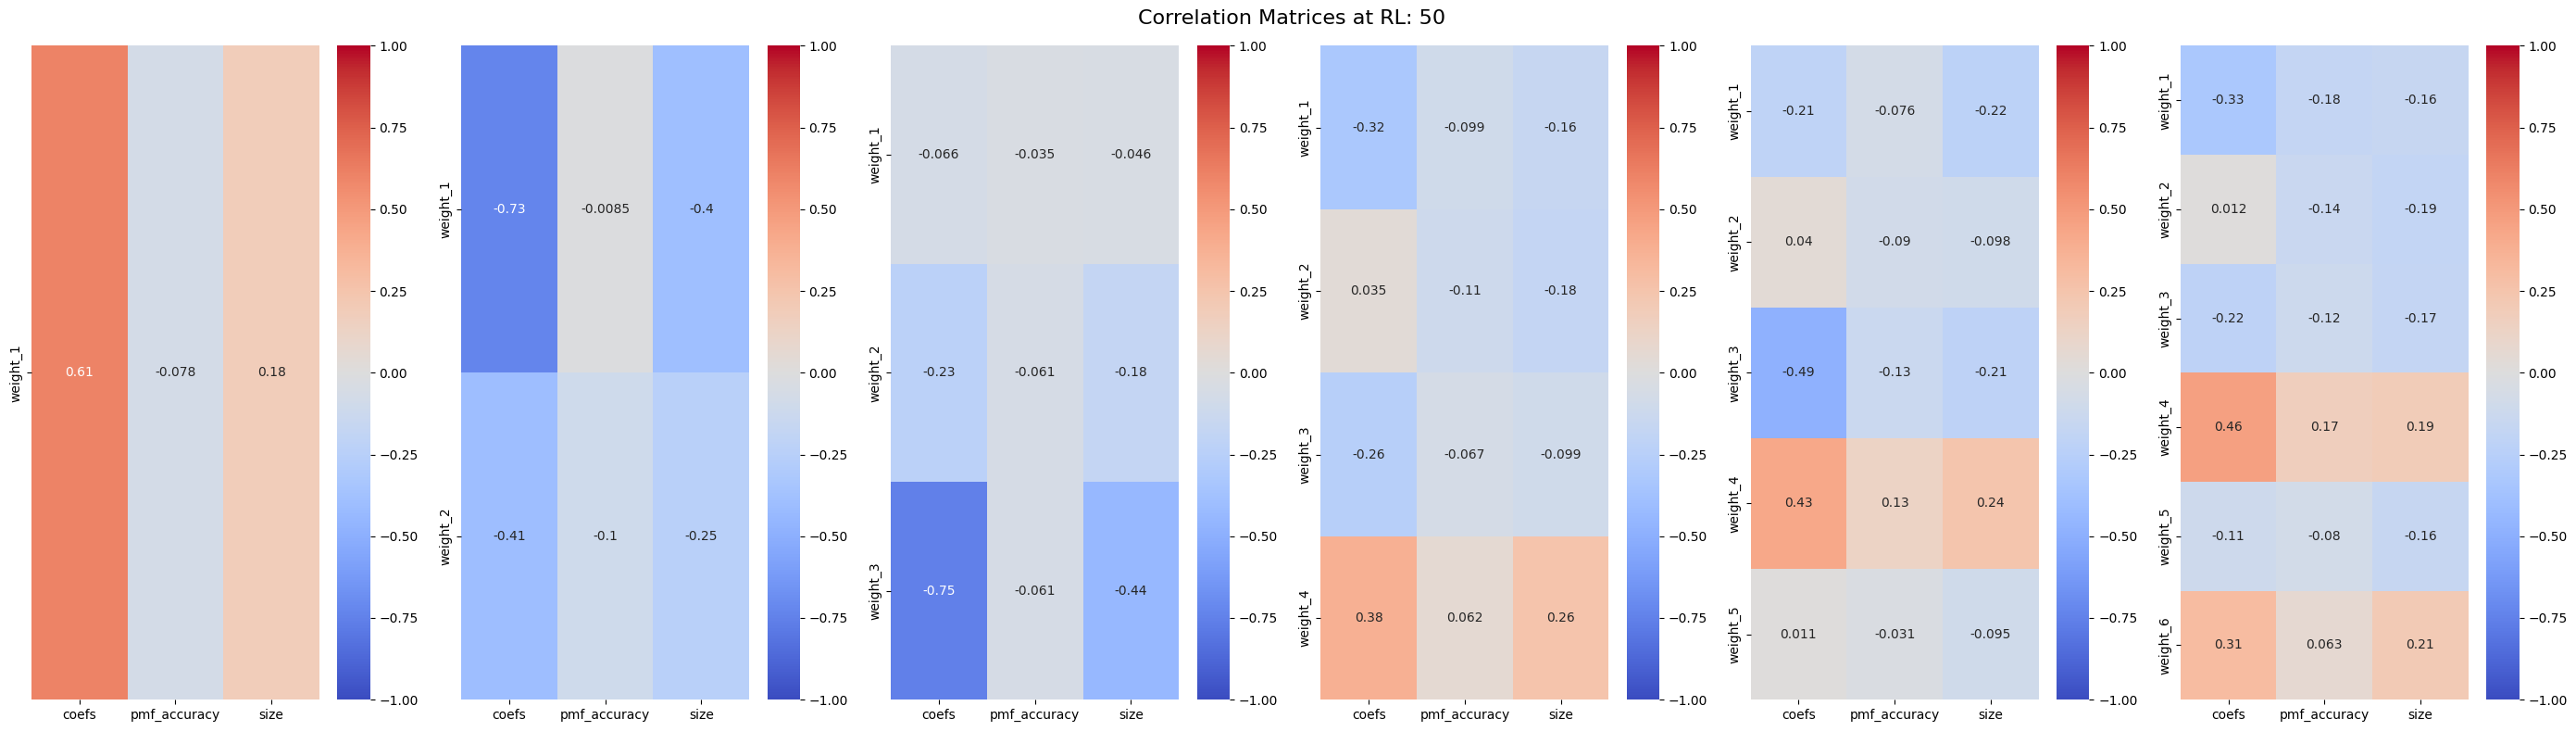

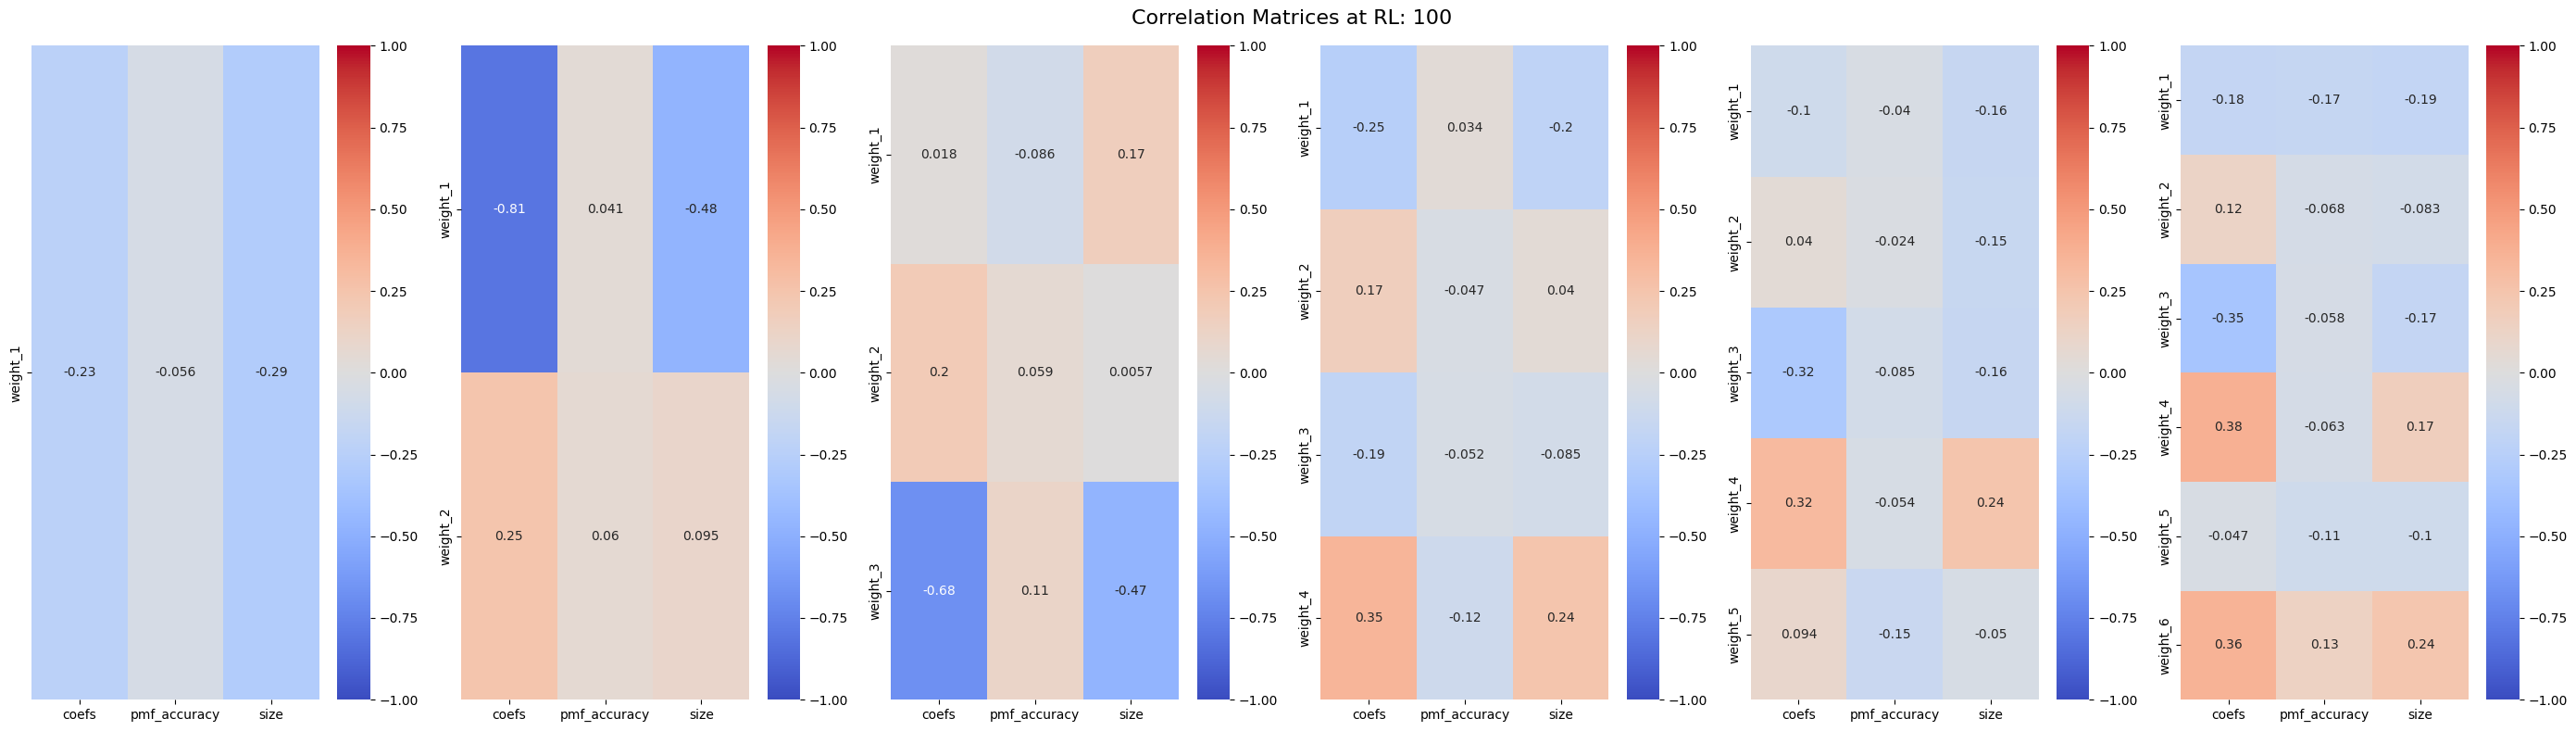

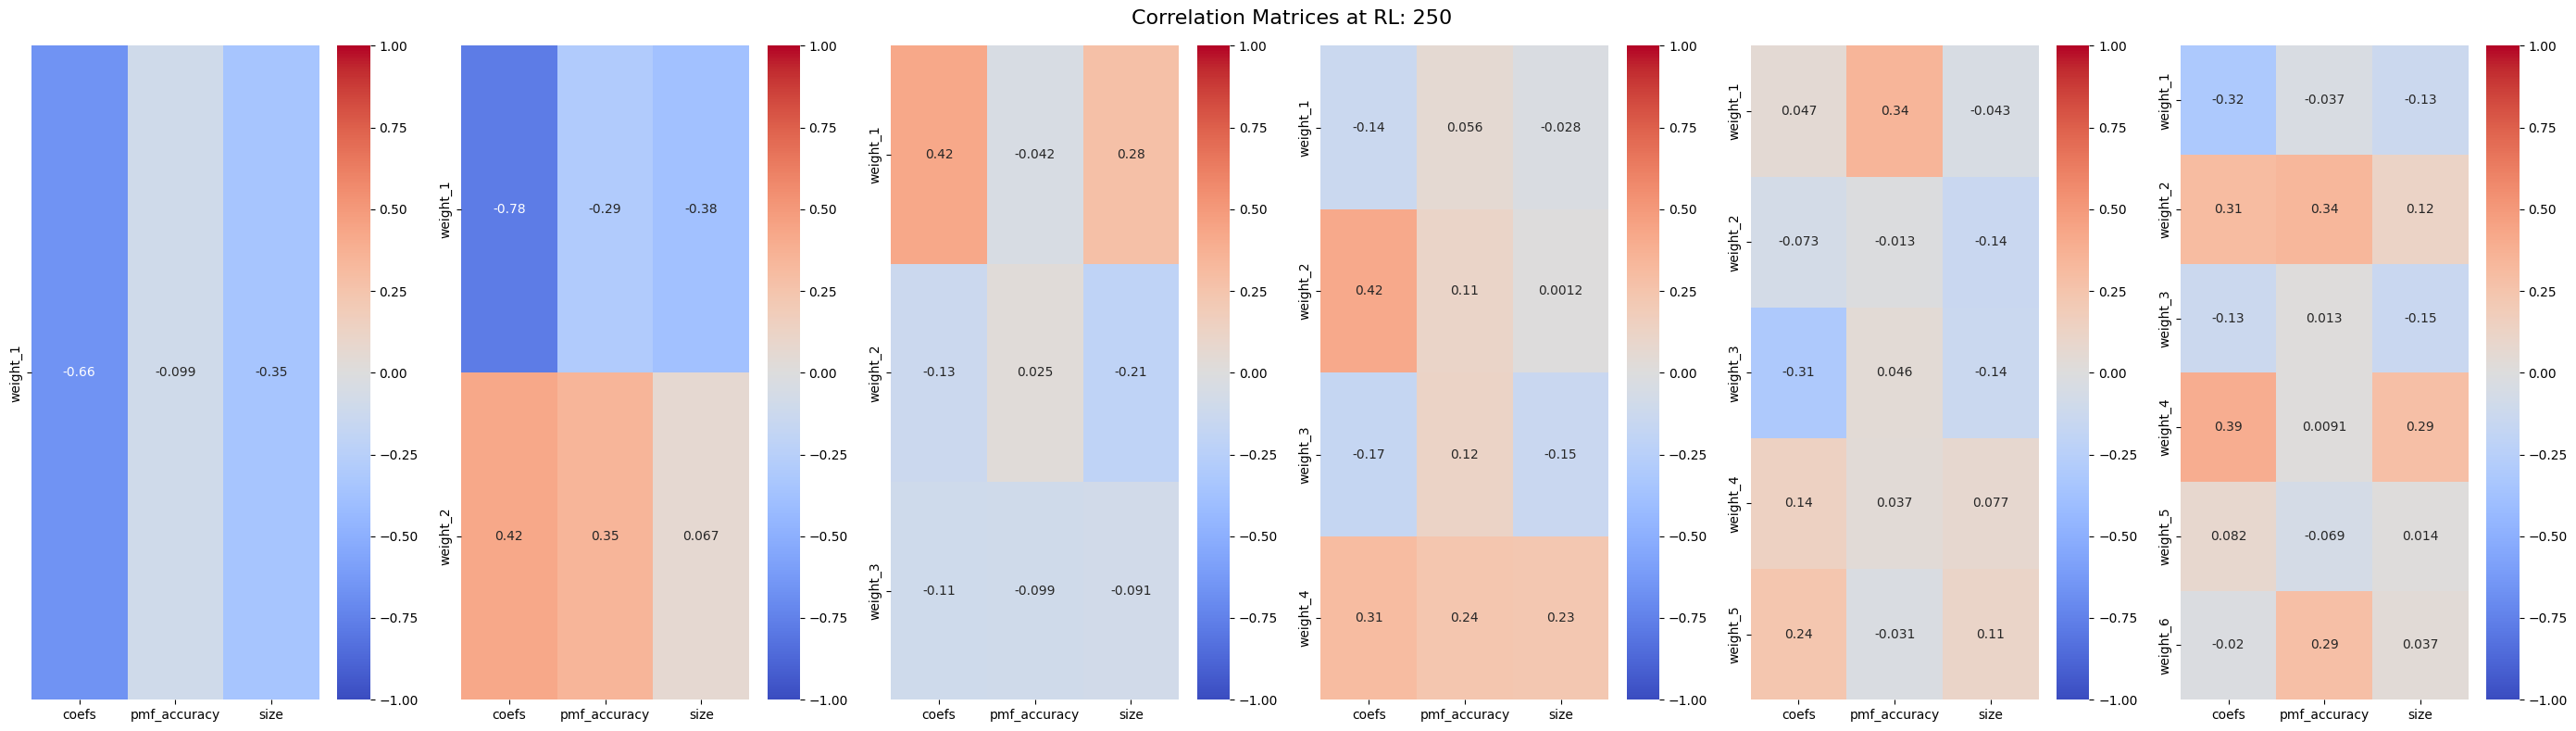

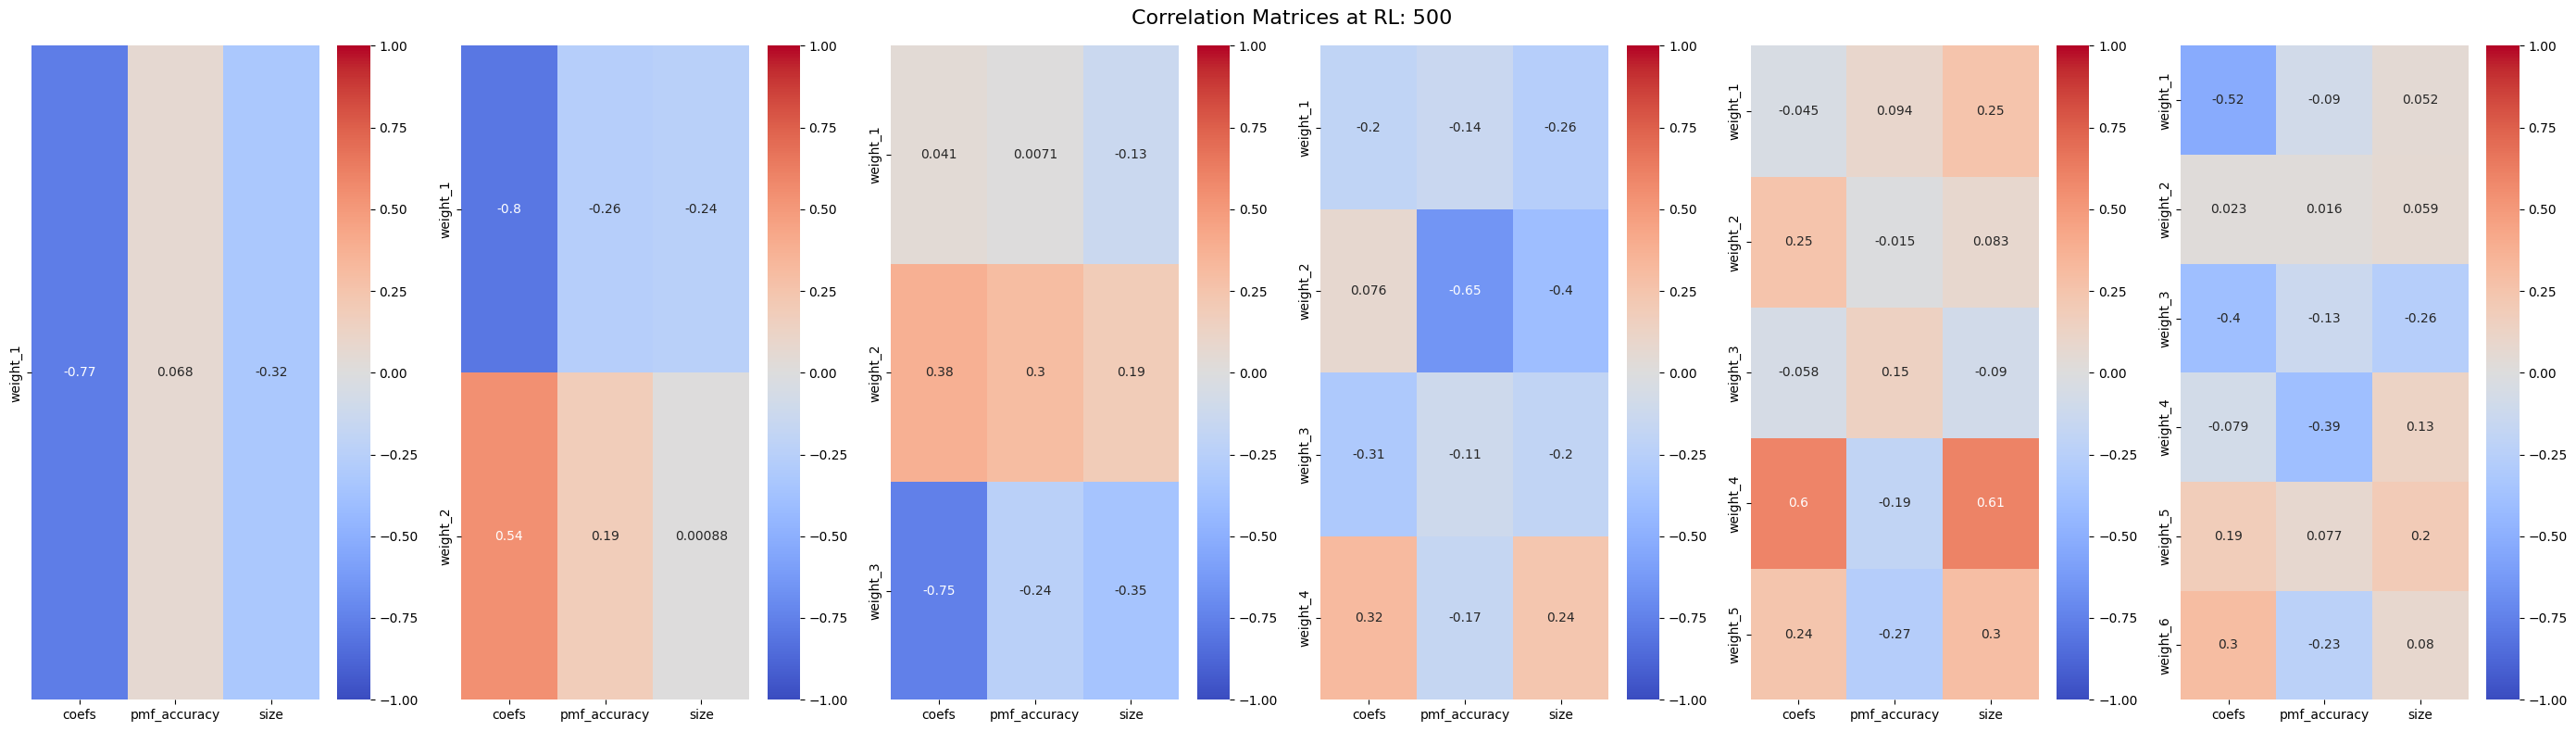

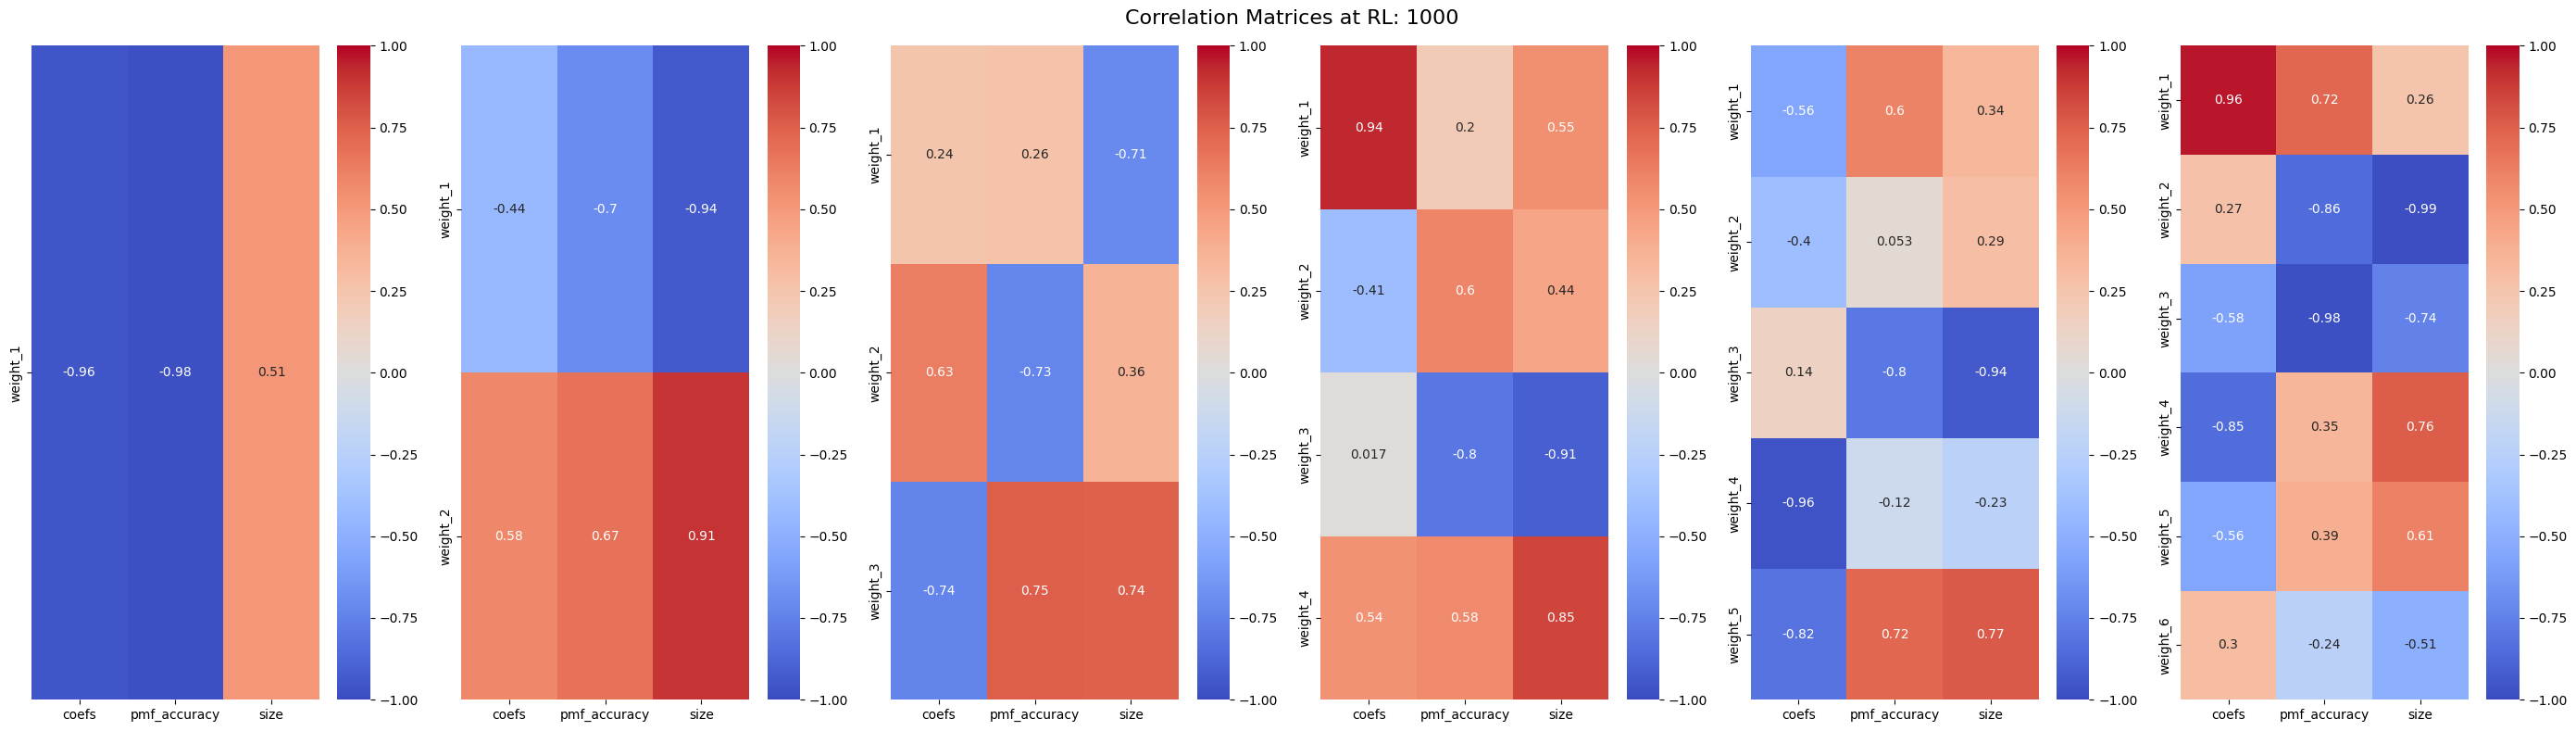

In [16]:
athletes = create_correlation_matrices()

In [17]:
athletes['1000_1']

,coefs,pmf_accuracy,size,weight_1
Dmitrii Sharafutdinov,NaN,0.768414,1229,1.274648
Jernej Kruder,0.757420,0.734744,1412,1.623061
Rustam Gelmanov,1.131032,0.774413,1358,1.268449
Sean Mccoll,0.845035,0.720913,1321,1.651077


In [18]:
athletes['500_1']

,coefs,pmf_accuracy,size,weight_1
Aleksei Rubtsov,1.286021,0.690355,1087.0,1.510879
David Barrans,0.554714,0.736181,696.0,2.176007
Dmitrii Sharafutdinov,1.548152,0.816011,1229.0,1.363521
Gabriele Moroni,1.107692,0.737973,746.0,1.032531
Guillaume Glairon Mondet,1.195256,0.784367,1138.0,1.786369
Jakob Schubert,1.329283,0.716696,954.0,1.564241
Jan Hojer,1.136150,0.710456,1164.0,1.609109
Jeremy Bonder,0.794825,0.762301,683.0,1.643870
Jernej Kruder,0.934350,0.722581,1412.0,1.731970
Jonas Baumann,0.629689,0.725793,712.0,2.713822
